This notebook shows how to prepare a [ResNetV2101 model from TensorFlow Hub](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5) for deploying to Vertex AI:

* Load the ResNetV2101 model from TensorFlow Hub.
* Export the model as a `SavedModel` resource so that it can handle raw image strings. 
* The utilities required to preprocess the input image strings will be embedded inside the exported `SavedModel` itself. 

## Initial imports

In [1]:
import tensorflow as tf 
import tensorflow_hub as hub
import os

## Constants

In [2]:
IMG_SIZE = 224
GCS_BUCKET = "BUCKET-NAME" # should contain the `gs://` identifier
CONCRETE_INPUT = "numpy_inputs"
MODEL_DIR = os.path.join(GCS_BUCKET, "concrete_model")

Rest of the notebook assumes that the `GCS_BUCKET` has been already created. 

## ResNetV2101 model

In [3]:
tfhub_model = tf.keras.Sequential(
    [hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5")]
)

tfhub_model.build([None, IMG_SIZE, IMG_SIZE, 3])

## Model export

In [4]:
def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(IMG_SIZE, IMG_SIZE))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(tfhub_model.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, IMG_SIZE, IMG_SIZE, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(tfhub_model, MODEL_DIR, signatures={"serving_default": serving_fn})

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Assets written to: gs://ccd-ahm-2022/concrete_model/assets


INFO:tensorflow:Assets written to: gs://ccd-ahm-2022/concrete_model/assets


**Notes on making the model accept string inputs**:

When dealing with images via REST or gRPC requests the size of the request payload can easily spiral up depending on the resolution of the images being passed. This is why, it is good practice to compress them reliably and then prepare the request payload.

## Load the model signature for crafting the request payload

In [5]:
loaded = tf.saved_model.load(MODEL_DIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)

Serving function input: bytes_inputs


## Deployment on Vertex AI

Go back to the GUI: https://console.cloud.google.com/vertex-ai/models:

* Import the model from `MODEL_DIR`. 
* Configure deployment parameters. 
* Deploy the model to an Endpoint once the model is imported into Vertex AI's Model Registry. 

## Test the endpoint

In [6]:
! gsutil cp gs://cloud-ml-data/img/flower_photos/daisy/100080576_f52e8ee070_n.jpg test.jpg

Copying gs://cloud-ml-data/img/flower_photos/daisy/100080576_f52e8ee070_n.jpg...
/ [1 files][ 26.2 KiB/ 26.2 KiB]                                                
Operation completed over 1 objects/26.2 KiB.                                     


In [7]:
import base64

with open("test.jpg", "rb") as f:
    data = f.read()
b64str = base64.b64encode(data).decode("utf-8")

In [14]:
from typing import Dict, List, Union

from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def predict_custom_trained_model_sample(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
    verbose: bool = False,
):
    """
    `instances` can be either single instance of type dict or a list
    of instances.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}

    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

    # The format of each instance should conform to the deployed model's prediction input schema.
    instances = instances if type(instances) == list else [instances]
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)

    # The predictions are a google.protobuf.Value representation of the model's predictions.
    predictions = response.predictions

    if verbose:
        for prediction in predictions:
            print(" prediction:", prediction)

    return predictions

In [15]:
instances = [{serving_input: {"b64": b64str}}]


# The magic numbers were retrieved from the Endpoint console:
# https://console.cloud.google.com/vertex-ai/locations/us-central1/models/
predictions = predict_custom_trained_model_sample(
    project="29880397572",
    endpoint_id="5702111282111447040",
    location="us-central1",
    instances=instances,
    verbose=True,
)

response
 deployed_model_id: 8163429633539178496
 prediction: [0.250591457, 0.194626302, -0.0140532702, 0.402600884, -0.928164, 0.836641908, -0.750856876, -1.18550014, -0.273119688, -0.977083564, -1.17410266, -2.0498178, -0.212214127, -1.86051607, 0.145549029, -0.115280904, -2.27409911, -1.79983175, -0.310122877, -0.652436495, 0.494947284, -1.26416564, -0.303813338, 2.00824332, -2.02947283, 0.406100035, -1.47534215, -1.86568451, -0.877228737, -0.246239409, -2.6560142, 0.00912472606, -1.12441134, -0.453974903, -0.205595866, -0.830915451, -1.5522964, 0.890759468, -1.09383655, -0.808113575, -1.22966015, -2.11738706, 0.287828118, -1.94342947, -0.943711281, 0.037689358, -0.611755, 0.214991361, -2.14857411, -0.283408731, -0.871614277, -1.24275661, -0.768078685, 0.867587566, 0.178276092, -1.38478732, 0.396636307, -0.200070232, -0.842316389, 2.32990146, -2.38132524, -1.1887, -0.499461234, -0.683241546, -0.802491903, -1.15744722, -1.6984756, -1.1094569, -0.321194768, -0.0335791707, -1.40636444,

In [12]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

--2022-09-19 06:43:06--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 209.85.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-09-19 06:43:07 (89.3 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



In [13]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

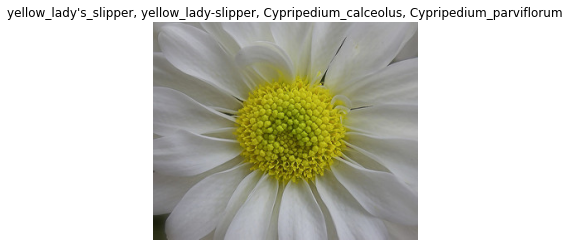

In [16]:
import numpy as np
import matplotlib.pyplot as plt

predicted_label = imagenet_int_to_str[int(np.argmax(predictions[0]))]

image = plt.imread("test.jpg")
plt.imshow(image)
plt.title(predicted_label)
plt.axis("off")
plt.show()

You can refer to [this resource](https://github.com/sayakpaul/deploy-hf-tf-vision-models/tree/main/hf_vision_model_vertex_ai) to learn how to include the postprocessing utilities into the `SavedModel` itself. Additionally, you will find a notebook that shows you how to handle this type of deployment in a programmatic manner.

## References

* https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/ml_ops/stage6/get_started_with_tf_serving_function.ipynb
* https://github.com/googleapis/python-aiplatform/blob/main/samples/snippets/prediction_service/predict_custom_trained_model_sample.py